<a href="https://colab.research.google.com/github/VimukthiRandika1997/Computer-Vision/blob/dev/Diffusers/MDP_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!git clone https://github.com/QianWangX/MDP-Diffusion.git
%cd MDP-Diffusion

Cloning into 'MDP-Diffusion'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 84 (delta 20), reused 25 (delta 8), pack-reused 33 (from 1)
Receiving objects: 100% (84/84), 86.09 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/MDP-Diffusion


In [3]:
!pip install diffusers transformers accelerate scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 58.1 MB/s eta 0:00:00


# Imports the libraries

In [4]:
from transformers import logging
import torch
from diffusers import DDIMScheduler
from diffusers import StableDiffusionPipeline
from tqdm.auto import tqdm
from torch import autocast
import numpy as np
from matplotlib import pyplot as plt

from utils import latents_to_pil, get_timesteps, prepare_latents, encode_text, visualize_images
from null_text_inversion import NullInversion

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
# Load the diffusion models
scheduler =DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                     set_alpha_to_one=False)
sdm_model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", scheduler=scheduler).to(torch_device)

vae = sdm_model.vae
tokenizer = sdm_model.tokenizer
text_encoder = sdm_model.text_encoder
unet = sdm_model.unet

vae = vae.to(torch_device).eval()
text_encoder = text_encoder.to(torch_device).eval()
unet = unet.to(torch_device)

vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.enable_gradient_checkpointing()

null_inversion = NullInversion(sdm_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:201: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresho

In [6]:
@torch.no_grad()
def img2img_sample(unet, generator, latents=None,
                   num_inference_steps=50, strength=1.0, guidance_scale=7.5,
                   uncond_embeddings_list=None,
                   do_classifier_free_guidance=True, prompt='A rabbit is eating an ice cream.',
                   return_noise_list=False, return_noisy_latents_list=False,
                   eta=0.0):

  # Set timesteps
  scheduler.set_timesteps(num_inference_steps)
  timesteps, num_inference_steps = get_timesteps(scheduler, num_inference_steps, strength)

  # Prepare latents
  if latents is None:
    latents = prepare_latents(vae, scheduler, 1, unet.in_channels, height=512, width=512, device=torch_device, generator=generator)

  # Prepare embeddings
  text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)
  uncond_embeddings = encode_text([""], tokenizer, text_encoder, torch_device)
  all_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)

  if not do_classifier_free_guidance:
    all_embeddings = all_embeddings[1].unsqueeze(0)

  if uncond_embeddings_list:
    text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)

  unet.eval()
  timesteps = scheduler.timesteps
  pbar = tqdm(timesteps)
  noise_pred_list = []
  noisy_latents_list = []

  for i, t in enumerate(pbar):
    pbar.set_description("Iter: {}".format(i))
    with autocast('cuda'):
      latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)
      if uncond_embeddings_list:
        all_embeddings = torch.cat([uncond_embeddings_list[i], text_embeddings], dim=0)
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=all_embeddings).sample

      # perform guidance
      if do_classifier_free_guidance:
          noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
          noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      noise_pred_list.append(noise_pred)

    latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
    noisy_latents_list.append(latents)

  if return_noisy_latents_list:
    return latents_to_pil(vae, latents)[0], noise_pred_list, noisy_latents_list
  elif return_noise_list:
    return latents_to_pil(vae, latents)[0], noise_pred_list
  else:
    return latents_to_pil(vae, latents)[0]

In [7]:
@torch.no_grad()
def mdp_epsilon(unet, generator, noise_list=None, latents=None,
                   amplify=1.0, num_inference_steps=50, strength=1.0, guidance_scale=7.5,
                   uncond_embeddings_list=None,
                   do_classifier_free_guidance=True, prompt='Photo of a zebra.',
                   return_noise_list=False, eta=0, linear_factor=1,
                   linear_factor_list=None):

  # Set timesteps
  scheduler.set_timesteps(num_inference_steps)
  timesteps, num_inference_steps = get_timesteps(scheduler, num_inference_steps, strength)

  # Prepare latents
  if latents is None:
    latents = prepare_latents(vae, scheduler, 1, unet.in_channels, height=512, width=512, device=torch_device, generator=generator)

  # Prepare embeddings
  text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)
  uncond_embeddings = encode_text([""], tokenizer, text_encoder, torch_device)
  all_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)

  if not do_classifier_free_guidance:
    all_embeddings = all_embeddings[1].unsqueeze(0)

  if uncond_embeddings_list:
    text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)

  unet.eval()
  timesteps = scheduler.timesteps
  pbar = tqdm(timesteps)
  noise_pred_list = []
  for i, t in enumerate(pbar):
    pbar.set_description("Iter: {}".format(i))
    with autocast('cuda'):
      latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)
      if uncond_embeddings_list:
        all_embeddings = torch.cat([uncond_embeddings_list[i], text_embeddings], dim=0)
      else:
        all_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=all_embeddings).sample

      # perform guidance
      if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      if linear_factor_list is None:
        noise_pred = linear_factor * amplify * noise_list[i] + (1 - linear_factor) * noise_pred
      else:
        noise_pred = linear_factor_list[i] * amplify * noise_list[i] + (1 - linear_factor_list[i]) * noise_pred

      noise_pred_list.append(noise_pred)

    latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample

  if return_noise_list:
    return latents_to_pil(vae, latents)[0], noise_pred_list
  else:
    return latents_to_pil(vae, latents)[0]

In [8]:
# create a list of linear factors
def create_linear_factors_list(num_inference_steps, tmax, tmin, type='constant', constant=1):

    manipulation_range = tmax - tmin
    linear_factors = np.zeros((num_inference_steps, ))
    if type == 'linear':
        linear_factors[50 - tmax: 50 - tmin] = np.linspace(1, 0, manipulation_range)
    elif type == 'cosine':
        linear_factors[50 - tmax: 50 - tmin] = np.cos(np.linspace(0, np.pi / 2, manipulation_range))
    elif type == 'exp':
        linear_factors[50 - tmax: 50 - tmin] = np.exp(np.linspace(0, -5, manipulation_range))
    elif type == 'constant':
        linear_factors[50 - tmax: 50 - tmin] = np.ones(manipulation_range) * constant

    return linear_factors

# Real Image Editing

In [9]:
# Real image inversion
image_path = "./example_images/horse.jpg"
prompt = ""  # prompt can be empty or a description of the image
(image_gt, image_enc), ddim_latents, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,0,0), verbose=True)

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

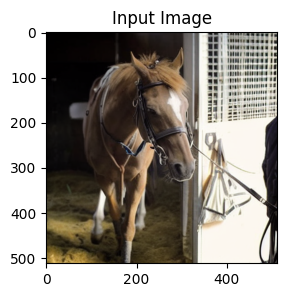

In [10]:
optimized_image, noise_list_1, xt_list_1 = img2img_sample(unet, generator=None, latents=ddim_latents,
                                prompt=prompt, uncond_embeddings_list=uncond_embeddings,
                                num_inference_steps=50, strength=1, guidance_scale=7.5,
                                do_classifier_free_guidance=True, return_noisy_latents_list=True, eta=0.0)

plt.figure(figsize=(3, 3))
plt.title('Input Image')
plt.imshow(optimized_image)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

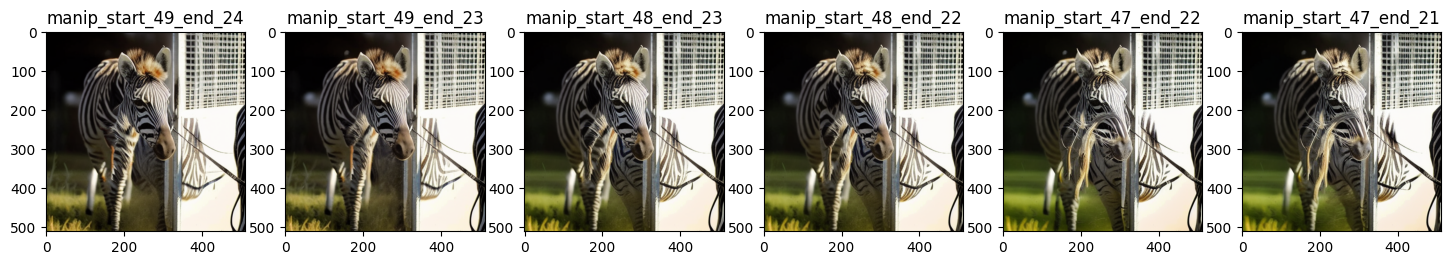

In [11]:
new_prompt = "Photo of a zebra"
manip_schedule_type = 'constant'
num_inference_steps = 50
tmax_range = (49, 46, -1)
tm_range = (25, 27, 1)
visualize_rows = 1
edited_image_list = []
title_list = []

for start in range(tmax_range[0], tmax_range[1], tmax_range[2]):
    for steps in range(tm_range[0], tm_range[1], tm_range[2]):
        end = start - steps
        linear_factor_list = create_linear_factors_list(num_inference_steps, start, end,
                                                        manip_schedule_type)

        edited_image, noise_list_2 = mdp_epsilon(unet, generator=None, latents=ddim_latents,
                                        noise_list=noise_list_1, amplify=1,
                                        uncond_embeddings_list=uncond_embeddings,
                                        prompt=new_prompt,
                                        num_inference_steps=num_inference_steps, strength=1,
                                        guidance_scale=7.5, return_noise_list=True,
                                        do_classifier_free_guidance=True,
                                        linear_factor_list=linear_factor_list)

        edited_image_list.append(edited_image)

        title_list.append('manip_start_{}_end_{}'.format(start, start - steps))

visualize_images(edited_image_list, cols=len(edited_image_list) // visualize_rows, titles=title_list)

# Synthetic Image Generation

<ipython-input-6-591ef15da7ed>:15: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = prepare_latents(vae, scheduler, 1, unet.in_channels, height=512, width=512, device=torch_device, generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

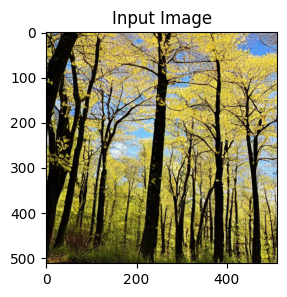

In [12]:
random_seed = 0
prompt = "Photo of a forest in the spring"
generator = torch.Generator(device=torch_device).manual_seed(random_seed)
optimized_image, noise_list_1, xt_list_1 = img2img_sample(unet, generator=generator, latents=None,
                                prompt=prompt, uncond_embeddings_list=None,
                                num_inference_steps=50, strength=1, guidance_scale=7.5,
                                do_classifier_free_guidance=True, return_noisy_latents_list=True)

plt.figure(figsize=(3, 3))
plt.title('Input Image')
plt.imshow(optimized_image)
plt.show()

<ipython-input-7-11b3fcf339f5>:15: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = prepare_latents(vae, scheduler, 1, unet.in_channels, height=512, width=512, device=torch_device, generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

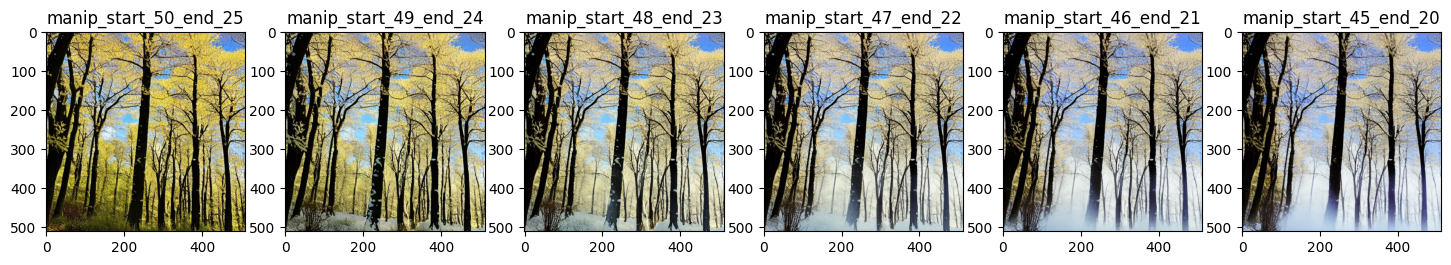

In [13]:
new_prompt = "A forest, winter"  # New prompt doesn't have to have the same structure as the input prompt
manip_schedule_type = 'constant'
num_inference_steps = 50
tmax_range = (50, 44, -1)  # manipulation start
tm_range = (25, 26, 1)  # manipulation duration
visualize_rows = 1
edited_image_list = []
title_list = []

for start in range(tmax_range[0], tmax_range[1], tmax_range[2]):
    for steps in range(tm_range[0], tm_range[1], tm_range[2]):
        end = start - steps
        linear_factor_list = create_linear_factors_list(num_inference_steps, start, end,
                                                        manip_schedule_type)

        generator = torch.Generator(device=torch_device).manual_seed(random_seed)
        edited_image, noise_list_2 = mdp_epsilon(unet, generator=generator, latents=None,
                                        noise_list=noise_list_1, amplify=1,
                                        uncond_embeddings_list=None,
                                        prompt=new_prompt,
                                        num_inference_steps=num_inference_steps, strength=1,
                                        guidance_scale=7.5, return_noise_list=True,
                                        do_classifier_free_guidance=True,
                                        linear_factor_list=linear_factor_list)

        edited_image_list.append(edited_image)

        title_list.append('manip_start_{}_end_{}'.format(start, end))

visualize_images(edited_image_list, cols=len(edited_image_list) // visualize_rows, titles=title_list)